In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
train.shape

(27481, 4)

In [5]:
train[train.text.isnull()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [6]:
#remove nan entries
train = train[train.text.isnull()==False].reset_index()

In [7]:
train.shape

(27480, 5)

In [8]:
%matplotlib inline

In [9]:
from matplotlib import pyplot as plt

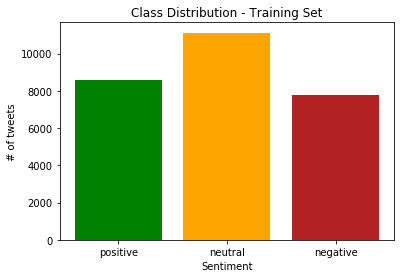

In [10]:
plt.bar(x=[0,1,2], height=[len(train[train.sentiment=='positive']),len(train[train.sentiment=='neutral']),len(train[train.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Training Set')
plt.show()

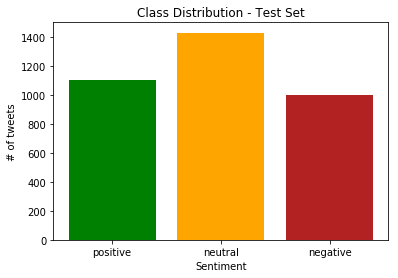

In [11]:
plt.bar(x=[0,1,2], height=[len(test[test.sentiment=='positive']),len(test[test.sentiment=='neutral']),len(test[test.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Test Set')
plt.show()

### Text pre-processing ###

We will create a bag of words - a matrix where there is a row corresonding to each tweet and a column for each word in all the tweets, with 1s and 0s indicating whether a given tween contains a given word or not.   

But first let's consider a common issue with tweets. Twitter users tend to use repeated letters to emphasize words. For example one may write 'I looove this pizza' or 'This movie is sooo goood!'. We would ideally want our classifier to understand that 'looove' is the same as 'love' and 'sooo goood' is the same as 'so good'. Therefore, we need to pre-process the text of each tweet to remove duplicate letters. However, we must be careful because some English words actually have repeating letters - for example 'goood' must be interpreted as 'good' and not 'god'.

Note: some of the next cells are commented to avoid running computationally intensive calculations multiple times. In contrast, the following code has been ran once and the results were stored in a .pkl file so that they can be loaded every time the notebook is used.

In [12]:
# #create count_vector and fit it to the train data
# from sklearn.feature_extraction.text import CountVectorizer
# count_vector = CountVectorizer(lowercase=True, stop_words='english') #  exclude common words in English
# count_vector.fit(train['text'].get_values())

In [13]:
# #transform train to bag of words matrix
# train_matrix = count_vector.transform(train['text']).toarray()
# words_matrix =  pd.DataFrame(train_matrix, columns = count_vector.get_feature_names())

In [14]:
#functions to write and save object (so that we don't have to run computationally intensive algorithms every time the notebook is re-opened)
import pickle
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [15]:
# #Algorithm to obtain a dictionary of non-existent words with repeated letters to correct English words
# import re
# all_words = words_matrix.columns.values
# word_dict = {}
# for word in all_words:
#     word_a = re.sub(r'(.)\1+', r'\1', word) #word with repeated characters reduced to 1 character
#     word_b = re.sub(r'(.)\1+', r'\1\1', word) #word with repeated characters reduced to 2 characters
    
#     #get count of each of the variations of the word in all sentences
#     count_ = words_matrix.word.sum(axis=0)
#     count_a = words_matrix[word_a].sum(axis=0) if word_a in all_words else 0
#     count_b = words_matrix[word_b].sum(axis=0) if word_b in all_words else 0
    
#     #determine which is the most common variation of the word
#     if count_ < count_a and count_a > count_b:
#         word_dict[word] = word_a
#     elif count_ < count_b and count_b > count_a:
#         word_dict[word] =  word_b
#     else:
#         word_dict[word] = word

# save_obj(word_dict, 'repeated_letters_dict')

In [16]:
word_dict = load_obj('repeated_letters_dict') #load pre-calculated dictionary

In [17]:
word_dict['goood']

'good'

In [20]:
word_dict['looove']

'love'

In [19]:
def remove_repeated_chars(sentence, word_dict):
    import string
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) #remove punctuation from string 
    translated = []
    #translate each word using word_dict - i.e. convert non-existent words with repeating letters to correct words
    for x in list(sentence.split()):
        t = word_dict.get(x.lower(), x)
        translated.append(t)
    newphrase = ' '.join(translated)
    return newphrase

In [21]:
#store copy of training and test sets' text field with no repeating characters
train_text_norm = train.text.apply(lambda x: remove_repeated_chars(x, word_dict))
test_text_norm = test.text.apply(lambda x: remove_repeated_chars(x, word_dict))

In [22]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector.fit(train_text_norm.get_values())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
#transform train to bag of words matrix
train_matrix_norm = count_vector.transform(train_text_norm).toarray()
train_df_norm =  pd.DataFrame(train_matrix_norm, columns = count_vector.get_feature_names())

In [24]:
#transform test to bag of words matrix, using count vectorizer fitted to train data
test_matrix_norm = count_vector.transform(test_text_norm).toarray()
test_df_norm =  pd.DataFrame(test_matrix_norm, columns = count_vector.get_feature_names())

In [24]:
# # erase pre-normalisation bags of words from memory
# train_matrix= None
# words_matrix = None

Do the same for the selected phrases in the training set:

In [25]:
#store copy of training set's selected_text field with no repeating characters
train_selected_norm = train.selected_text.apply(lambda x: remove_repeated_chars(x, word_dict))

In [26]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector.fit(train_selected_norm.get_values())

#transform train to bag of words matrix
selected_matrix_norm = count_vector.transform(train_selected_norm).toarray()
selected_df_norm =  pd.DataFrame(selected_matrix_norm, columns = count_vector.get_feature_names())

### Baseline Model ###

We will first test a simple model which is based on the balance between the count of words that are commonly encountered in positive sentiment tweets and words commonly used in negative sentiment tweets. If a given tweet contains more 'positive' words than 'negative' words it is classified as positive while if it contains more 'negative' words it is classified as negative. If there is the same number of 'positive' and 'negative' words (or the difference between the two counts is not greater than a pre-defined limit) then the tweet is classified as 'neutral'.

Let's first calculate some statistics about the frequency of occurrence of each word. We start by counting the number of samples that contain each word in the entire training dataset and in positive and negative samples seperately:

In [43]:
def get_word_stats(matrix, labels, thres_pct=0.5):
    #thres_pct: minimum percentage of occurence in a particular class for word to be retained
    
    #Count total occurences of each word
    total_freq = matrix.astype(bool).sum(axis=0).sort_values(ascending=False)
    
    #Count occurences of each word in positive and negative sentiment samples
    matrix['sentiment'] = labels    #add label column to word_matrix
    positive_freq = matrix[matrix.sentiment == 'positive'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)
    negative_freq = matrix[matrix.sentiment == 'negative'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)
    
    #Concatenate frequency counts into a single dataframe
    words_stats = pd.concat([total_freq, positive_freq.reindex(total_freq.index), negative_freq.reindex(total_freq.index)], axis=1)
    words_stats = words_stats.rename(columns={0: 'total_count', 1: 'pos_count', 2: 'neg_count'})
    
    #Calculate percentage of phrases that contain each word that have pos or neg sentiment
    words_stats['pos_pct'] = words_stats['pos_count']/words_stats['total_count']
    words_stats['neg_pct'] = words_stats['neg_count']/words_stats['total_count']
    
    #Remove words that do not have a particular class (pos or neg) mainly associated with them
    words_stats_reduced = words_stats[(words_stats.pos_pct>=thres_pct)|(words_stats.neg_pct>=thres_pct)]
    
    #Store words that appear frequently in positive or negative tweets
    pos_words = words_stats_reduced[words_stats_reduced.pos_pct>words_stats_reduced.neg_pct].index.values
    neg_words = words_stats_reduced[words_stats_reduced.pos_pct<words_stats_reduced.neg_pct].index.values
    
    return words_stats_reduced, pos_words, neg_words

In [31]:
word_stats, pos_words, neg_words = get_word_stats(train_df_norm, train.sentiment, thres_pct=0.5)

Let's see some of the most common words appearing in positive and negative sentiment tweets:

In [51]:
word_stats[word_stats.pos_pct>word_stats.neg_pct].sort_values('pos_count',ascending=False).head(10)

,total_count,pos_count,neg_count,pos_pct,neg_pct
day,1924,1141.0,308.0,0.593035,0.160083
good,1507,1018.0,198.0,0.675514,0.131387
love,1106,861.0,47.0,0.778481,0.042495
happy,953,817.0,43.0,0.857293,0.045121
mothers,636,555.0,13.0,0.872642,0.020440
thanks,655,550.0,19.0,0.839695,0.029008
great,599,467.0,33.0,0.779633,0.055092
hope,580,389.0,52.0,0.670690,0.089655
fun,515,337.0,68.0,0.654369,0.132039
nice,424,329.0,29.0,0.775943,0.068396


In [52]:
word_stats[word_stats.neg_pct>word_stats.pos_pct].sort_values('neg_count',ascending=False).head(10)

,total_count,pos_count,neg_count,pos_pct,neg_pct
miss,600,50.0,414.0,0.083333,0.690000
sad,469,6.0,384.0,0.012793,0.818763
sorry,470,21.0,336.0,0.044681,0.714894
bad,464,46.0,291.0,0.099138,0.627155
feel,515,109.0,283.0,0.211650,0.549515
hate,316,7.0,255.0,0.022152,0.806962
sick,252,11.0,196.0,0.043651,0.777778
sucks,207,2.0,177.0,0.009662,0.855072
tired,257,20.0,172.0,0.077821,0.669261
ugh,217,15.0,165.0,0.069124,0.760369


We now create a function for the baseline model:

In [44]:
def intersection(list1, list2): 
    return list(set(list1) & set(list2)) 

def baseline_classifier(matrix, correct_labels, pos_words, neg_words, limit=0, plot_confusion=True):
    #Remove words that appear in pos_words or neg_word but not in the texts to be classified
    pos_words = intersection(pos_words, matrix.columns.values)
    neg_words = intersection(neg_words, matrix.columns.values)
    #Calculate balance of 'positive' and 'negative' words in each text
    words_balance = pd.DataFrame(matrix[pos_words].sum(axis=1)-matrix[neg_words].sum(axis=1)).rename(columns={0:'balance'})
    #Classify text based on balance. If abs(balance)<limit then 'neutral'
    pred = words_balance.balance.apply(lambda x: 'positive' if x>limit else ('negative' if x<-limit else 'neutral')).values
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('Results')
    print('Accuracy score: ', format(accuracy_score(correct_labels, pred)))
    print('Precision score: ', format(precision_score(correct_labels, pred,average=None)))
    print('Recall score: ', format(recall_score(correct_labels, pred,average=None)))
    print('F1 score: ', format(f1_score(correct_labels, pred,average=None)))
    
    if plot_confusion:
        from sklearn.metrics import confusion_matrix
        import seaborn as sns

        #Calculate confusion matrix
        cm = confusion_matrix(correct_labels, pred, ['positive','neutral','negative'])
        
        #Plot confusion matrix heatmap
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix') 
        ax.xaxis.set_ticklabels(['positive','neutral','negative'])
        ax.yaxis.set_ticklabels(['positive','neutral','negative'])
        plt.show()
        
    
    return pred

**Baseline Model using full text**

Run on training set with limit=0 (i.e. if n_pos>n_neg then 'positive'):

Results
Accuracy score:  0.7433406113537118
Precision score:  [0.75558167 0.79406769 0.69983211]
Recall score:  [0.82637193 0.54664028 0.9228618 ]
F1 score:  [0.78939292 0.64752264 0.7960199 ]


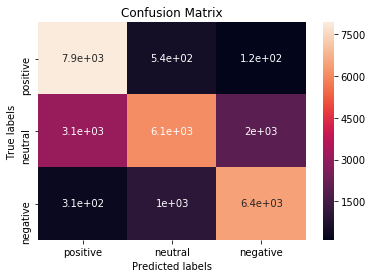

In [53]:
train_pred = baseline_classifier(train_df_norm,train.sentiment.values,pos_words,neg_words,limit=0,plot_confusion=True)

Run on training set with limit=1 (i.e. if n_pos-n_neg>1 then 'positive'):

Results
Accuracy score:  0.7388282387190684
Precision score:  [0.91105007 0.62765147 0.87244679]
Recall score:  [0.55417042 0.88899883 0.71172221]
F1 score:  [0.68914815 0.73580762 0.78393121]


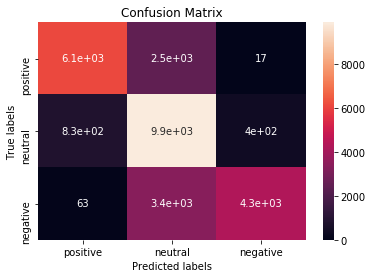

In [54]:
train_pred = baseline_classifier(train_df_norm,train.sentiment.values,pos_words,neg_words,limit=1,plot_confusion=True)

While recall improves for 'neutral' when lim>0, it significantly drops for 'positive' and 'negative' tweets.

Run on test set with limit=0:

Results
Accuracy score:  0.6120543293718166
Precision score:  [0.62085308 0.61137441 0.60603933]
Recall score:  [0.65434565 0.45104895 0.7824116 ]
F1 score:  [0.63715953 0.51911469 0.68302335]


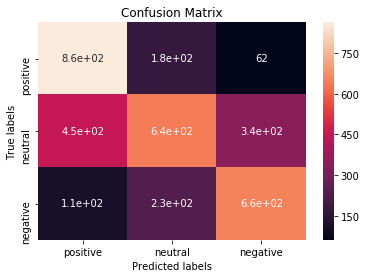

In [56]:
test_pred = baseline_classifier(test_df_norm,test.sentiment.values,pos_words,neg_words,limit=0,plot_confusion=True)

**Baseline Model using selected_text**

We will now try training the baseline classifier with the selected_text from the training set instead of the full text of each document. This will help to only identify words that are truely associated with a given sentiment.

In [57]:
word_stats_selected, pos_words_selected, neg_words_selected = get_word_stats(selected_df_norm, train.sentiment, thres_pct=0.5)

Results
Accuracy score:  0.6997736276174307
Precision score:  [0.70238095 0.65743243 0.75309735]
Recall score:  [0.64835165 0.68041958 0.77153218]
F1 score:  [0.67428571 0.66872852 0.76220331]


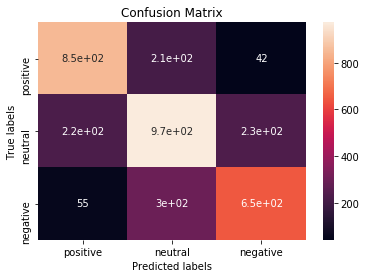

In [58]:
test_pred = baseline_classifier(test_df_norm,test.sentiment.values,pos_words_selected,neg_words_selected,limit=0,plot_confusion=True)

The performance is indeed improved when we only focus on the words in the selected_text field.

### Machine Learning models ###

**Model pipeline**

Create pipeline to test the performance of different machine learning models:

In [49]:
def run_model(model, model_name, train_data, train_labels, test_data, test_labels):
    
    #encode training labels to an integer format that is interpretable by all sklearn classification models
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(train_labels.astype(str))
    train_labels_encoded = le.transform(train_labels.astype(str))
    
    #Fit model to training data
    model.fit(train_matrix_norm, train_labels_encoded)
    
    #Test model's performance on training data
    train_pred = model.predict(train_data)
    train_pred = le.inverse_transform(train_pred)
    
    #Test model's performance on test data
    test_pred = model.predict(test_data) 
    test_pred = le.inverse_transform(test_pred)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    #Prin performance metrics
    print(model_name)
    print()
    print('Results on training set:')
    print('Accuracy score: ', format(accuracy_score(train_labels, train_pred)))
    print('Precision score: ', format(precision_score(train_labels, train_pred,average=None)))
    print('Recall score: ', format(recall_score(train_labels, train_pred,average=None)))
    print('F1 score: ', format(f1_score(train_labels, train_pred,average=None)))
    print('---------------------------------------------------------------------')
    print('Results on test set:')
    print('Accuracy score: ', format(accuracy_score(test_labels, test_pred)))
    print('Precision score: ', format(precision_score(test_labels, test_pred,average=None)))
    print('Recall score: ', format(recall_score(test_labels, test_pred,average=None)))
    print('F1 score: ', format(f1_score(test_labels, test_pred,average=None)))
    print('---------------------------------------------------------------------')
    
    #Plot confusion matrix for test set
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(test.sentiment.values, test_pred, ['positive','neutral','negative'])

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix - Test Set') 
    ax.xaxis.set_ticklabels(le.inverse_transform([0,1,2]))
    ax.yaxis.set_ticklabels(le.inverse_transform([0,1,2]))
    plt.show()
    
    return train_pred, test_pred 

In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

models = {'Multinomial Naive Bayes': MultinomialNB(),
          'Bernoulli Naive Bayes':BernoulliNB(),
          'Logistic Regression': LogisticRegression(random_state=42),
          'KNN': KNeighborsClassifier(n_neighbors=5)}

Multinomial Naive Bayes

Results on training set:
Accuracy score:  0.8448689956331877
Precision score:  [0.87955025 0.81405415 0.85842461]
Recall score:  [0.8042668  0.8628227  0.85842461]
F1 score:  [0.84022556 0.83772926 0.85842461]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6550650820599887
Precision score:  [0.68287037 0.59900683 0.71765817]
Recall score:  [0.58941059 0.67482517 0.68902992]
F1 score:  [0.63270777 0.63465965 0.70305273]
---------------------------------------------------------------------


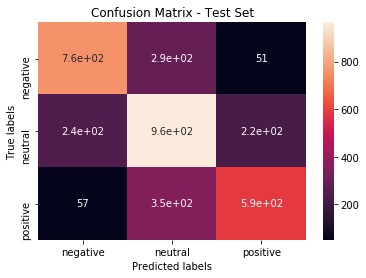

In [51]:
train_pred, test_pred = run_model(models['Multinomial Naive Bayes'],'Multinomial Naive Bayes',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values)

Bernoulli Naive Bayes

Results on training set:
Accuracy score:  0.8109170305676856
Precision score:  [0.91520417 0.71987153 0.90598406]
Recall score:  [0.67690528 0.92740847 0.78151946]
F1 score:  [0.77822104 0.81056645 0.83916171]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6346915676287493
Precision score:  [0.74300699 0.54709977 0.79182156]
Recall score:  [0.42457542 0.82447552 0.5793291 ]
F1 score:  [0.54036872 0.65774059 0.66910995]
---------------------------------------------------------------------


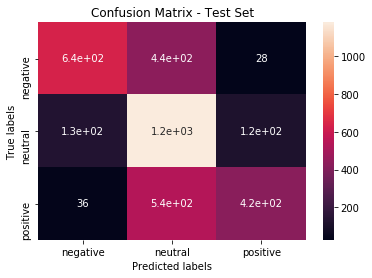

In [52]:
train_pred, test_pred = run_model(models['Bernoulli Naive Bayes'],'Bernoulli Naive Bayes',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values)

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression

Results on training set:
Accuracy score:  0.867467248908297
Precision score:  [0.89618172 0.83700366 0.8852862 ]
Recall score:  [0.82650045 0.88549069 0.88126311]
F1 score:  [0.8599318  0.86056473 0.88327007]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6955291454442558
Precision score:  [0.70866142 0.63368162 0.78290766]
Recall score:  [0.62937063 0.72097902 0.7225748 ]
F1 score:  [0.66666667 0.6745175  0.7515323 ]
---------------------------------------------------------------------


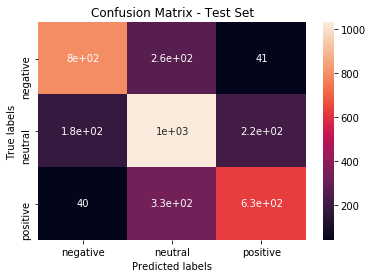

In [53]:
train_pred, test_pred = run_model(models['Logistic Regression'],'Logistic Regression',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values)

In [54]:
#create smaller count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector_small = CountVectorizer(max_features=100, lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector_small.fit(train_text_norm.get_values())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [55]:
#transform train to bag of words matrix
train_matrix_norm_small = count_vector_small.transform(train_text_norm).toarray()
train_df_norm_small =  pd.DataFrame(train_matrix_norm_small, columns = count_vector_small.get_feature_names())

In [56]:
#transform test to bag of words matrix, using count vectorizer fitted to train data
test_matrix_norm_small = count_vector_small.transform(test_text_norm).toarray()
test_df_norm_small =  pd.DataFrame(test_matrix_norm_small, columns = count_vector_small.get_feature_names())

In [ ]:
train_pred, test_pred = run_model(models['KNN'],'KNN',train_matrix_norm,train.sentiment.values,test_matrix_norm,test.sentiment.values)